# Natural gas hydrates - Phase Equilibria
Liquid(Water)-Solid(Hydrate-sI)-Gas(Methane) Equilibria
> cf. Segtovich et al., 2016, supplementary material 

# Overview

## Equilibrium criteria

Equality of pressure, temperature and chemical potential among all phases for each component 

$$\mu_w^L=\mu_w^H$$
$$\mu_w^G=\mu_w^H$$
$$\mu_g^L=\mu_g^H$$
$$\mu_g^G=\mu_g^H$$

Note that the solubility of water in the gas phase is known to be small ( circa 100 ppm ) and does not significantly affect the chemical potential of other components in the gas phase
Similarly, the solubility of guest components in the liquid water phase is known to be small ( even lower than 1 ppm ) and does not significantly affect the chemical potential of water in that liquid water phase.

Therefore we are able to split the problem in two sections with .

First we can calculate phase equilibria using equality of chemical componets present in significant ammount in each phase

$$\mu_w^L=\mu_w^H$$

$$\mu_g^G=\mu_g^H$$

Then we may calculate the solubility of guest components in water and of water in gas phase at equilibrium condition, if we want to do so.

## Models

Regarding models for said chemical potentials in each phase,

We know an equation of state for the gas phase, from which we are able to calculate fugacity as function of temperature, of either density or pressure, and of composition.

$$f_g^G \leftarrow f_g^G(T,P,x_g^G)$$

We know an equation of state for the adsorption of guest components in an hypothesized empty lattice phase, from which we are able to calculate chemical potential difference for water between filled and empty lattice conditions, as well as composition of guests in the lattice, as function of temperature, and fugacity of the guests in the hydrate phase.

$$\Delta\mu_w^{H-EL} \leftarrow \Delta\mu_w^{H-EL}(T,f_g^H)$$

Regarding the liquid water phase and the hypothesized empty lattice phase, we can calculate a difference in the cehmical potential of water between these phases from classical thermodynamics integration as a function of temperature and pressure, given a initial condition of T0, P0 and a reference chemical potential difference.

$$\Delta\mu_w^{Lw-EL} \leftarrow \Delta\mu_w^{Lw-EL}(T,P)$$

## Devised algorithm

Having hold of these models we can devise an algorithm to achieve equality of chemical potential in the following 

* $\mu_g^G=\mu_g^H$ is met by means o meeting $f_g^G=f_g^H$

* $\mu_w^{Lw}=\mu_g^H$ is met by means of meeting $\mu_w^{Lw}-\mu_w^{EL}=\mu_g^H-\mu_w^{EL}$ which we name $\Delta\mu_w^{Lw-EL}=\Delta\mu_g^{H-EL}$

Then,

Equality of guest fugacity is met by **direct substitution** of gas fugacity into hydrate model:

$$f_g^H \impliedby f_g^G(P,T,x_g^G)$$

making the functionality of $\Delta\mu_w^{H-EL}(T,P,f_g^H)$ become $\Delta\mu_w^{H-EL}(T,P,f_g^H(T,P,x_g^G))$ therefore $\Delta\mu_w^{H-EL}(T,P,x_g^G)$.

For given $P$ and $x_g^G$ , the equality of the chemical potential differences for water is met by numerical solution of this equality for $T$.

$T^{SOLUTION} \leftarrow SOLVE \left({\Delta\mu_w^{H-EL}(T<^{SOLVE},P<^{GIVEN},x_g^G<^{GIVEN})=\Delta\mu_w^{Lw-EL}(T<^{SOLVE},P<^{GIVEN})}\right)$

Implementation:

In [1]:
import numpy as np

# Implement model for calculation of fugacity in gas phase
e.g. Peng-Robinson [REF](DOI) (Poling, Abreu Lecture Notes, PR original)

In [2]:
def PR_fug_G(T,P,x): #Peng-Robinson
    R = 8.31446 #m^3*Pa/(mol*K)  
    
    Ncomp=1 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT

    k=np.zeros([Ncomp,Ncomp])
    Tc=np.ones([Ncomp])
    Pc=np.ones([Ncomp])
    w=np.ones([Ncomp])
    
    sigma=1+np.sqrt(2)
    epsilon=1-np.sqrt(2)
    
    #e.g.METHANE
    Tc[0]=-82.59+273#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    Pc[0]=45.99*1e5#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    w[0]=0.010#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    
    ai_crit = (0.45724*((R)**2)*(Tc[:])**2)/(Pc[:])
    bi_crit = (0.07780*(R)*(Tc[:]))/(Pc[:])
    
    PRk = 0.37464 + 1.54226*w[:]-0.26992*(w[:])**2
    
    alphaAi= (1. + PRk*(1.-np.sqrt(T/Tc[:])))**2
    
    ThetaAi=ai_crit[:]*alphaAi[:]
    
    b_m=sum(x*bi_crit)
    
    Theta_m=0
    for i in range(Ncomp):
        for j in range(Ncomp):
            Theta_m += x[i]*x[j]*np.sqrt(ThetaAi[i]*ThetaAi[j])*(1.- k[i,j])
            
    Theta_m=sum(sum(np.array( #sums over all elements of the following temporary 2d array
        [x[i]*x[j]*np.sqrt(ThetaAi[i]*ThetaAi[j])*(1.- k[i,j])
        for (i,j) in np.ndindex(Ncomp,Ncomp)]).reshape((Ncomp,Ncomp))        
    ))            
    
    c0 = -(b_m**3)*sigma*epsilon + (-R*T*sigma*epsilon*(b_m**2)-b_m*Theta_m)/P
    c1 = (b_m**2)*(sigma*epsilon-epsilon-sigma) + ((R*T)*(-sigma*b_m-epsilon*b_m) + Theta_m)/P
    c2 = epsilon*b_m+sigma*b_m-b_m-R*T/P
    c3 = 1
        
    V = np.roots(np.array([c3,c2,c1,c0]))

    
    V = V[ np.isreal(V) ].real #filter out complex roots
    V = V[ np.where( V > b_m ) ] #filter out non physical roots

    V = max(V) #GASphase-only EOS implementation  
    
#    print("debug V=",V*1000)
    
    dbidni=bi_crit[:]

    dthetaidni=np.zeros(Ncomp)
    for i in range(Ncomp):
        sum1 = 0.
        for j in range(Ncomp):
            sum1 += x[j]*np.sqrt(ThetaAi[j])*(1.-k[i,j])

        dthetaidni[i]=np.sqrt(ThetaAi[i])*sum1

    qsi = (1./(b_m*(epsilon-sigma)))*np.log((V+epsilon*b_m)/(V+sigma*b_m))
    
    lnPhi = (((dbidni[:]/b_m)*((P*V)/(R*T)-1) 
                -np.log(P*(V-b_m)/(R*T)) 
                -(Theta_m/(R*T))*qsi)*
                ((2*dthetaidni[:]/Theta_m)- 
                (dbidni[:]/b_m)))

    fug = np.exp(lnPhi)*x*P

    return fug, V

def test_PR():
    R = 8.31446 #m^3*Pa/(mol*K)  
    tryT=273
    tryP=1e5
    tryx=np.array([1.])
    ans=PR_fug_G(tryT,tryP,tryx)
    print("Z",tryP*ans[1]/(R*tryT))
    print("f",ans[0])

    tryT=273
    tryP=1e9
    tryx=np.array([1.])
    ans=PR_fug_G(tryT,tryP,tryx)
    print("Z",tryP*ans[1]/(R*tryT))
    print("f",ans[0])

    tryT=298
    tryP=1e5
    tryx=np.array([1.])
    ans=PR_fug_G(tryT,tryP,tryx)
    print("Z",tryP*ans[1]/(R*tryT))
    print("f",ans[0])
    
    tryT=298
    tryP=1e9
    tryx=np.array([1.])
    ans=PR_fug_G(tryT,tryP,tryx)
    print("Z",tryP*ans[1]/(R*tryT))
    print("f",ans[0])
    return

In [3]:
#test
test_PR()

Z 0.997061903565
f [ 99706.49713971]
Z 12.685200677
f [  1.71815606e+13]
Z 0.997781120382
f [ 99778.1888341]
Z 11.7011817254
f [  8.32866536e+12]


# The model for $\Delta\mu_w^{H-EL}$, van der Waals and Platteeuw, 1959
langmuir constants as function of temperature
$$C_{i,j}=\frac{A_{i,j}}{T}exp\frac{B_{i,j}}{T}$$

composition as occupancy of cavities as function of langmuir constants and fugacities
$$\Theta_{i,j}=\frac{C_{i,j}f_{i}}{1+\sum_k\left[{C_{k,j}f_{k}}\right]}$$

chemical potential difference as function of occupancy
$$\Delta\mu_w^{H-EL}=RT\left( \sum_j\left[{\nu_j ln\left(1- \sum_i\left[{\Theta_{i,j}}\right]\right)}\right] \right)$$

where A and B are empirical parameters presented by Parrish and Prausnitz (...), Munck (...), Sloan (...), Segtovich, 2016.

In [4]:
def vdwnp_H_EL(T,fug):
    
#parameters

    R = 8.31446 #!m^3*Pa/(mol*K)  

    Nguest=1    #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components
    Ncav=2 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure

    UCnw = 46 #sI #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    ni = np.array([2/UCnw, 6/UCnw]) #sI #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure

    Nguest = 1
    A_pSWP = np.zeros([Nguest,Ncav])
    B_pSWP = np.zeros([Nguest,Ncav])
    
    #methane
    A_pSWP[0,0] = .7228e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,0] = 3187. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    A_pSWP[0,1] = 23.35e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,1] = 2653. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPU2*T components,structure

#LANGMUIR CONSTANTS
    Clang=np.zeros([Nguest,Ncav])
    for i in range(Nguest):
        for j in range(Ncav):
            Clang[i,j] = (A_pSWP[i,j]/T)*np.exp(B_pSWP[i,j]/T) #Pa

#OCCUPANCY
    occ=np.zeros([Nguest,Ncav])
    for j in range(Ncav):
        sum1 = 0.      
        for i in range(Nguest):
            sum1 += Clang[i,j]*fug[i]

        for i in range(Nguest):
            occ[i,j] = Clang[i,j]*fug[i]/(1.+sum1)         
#vdwnp
    Dmu_H_EL = 0.
    for j in range(Ncav):
        sum1 = 0.
        for i in range(Nguest):
            sum1 += occ[i,j]
            
        Dmu_H_EL += ni[j]*np.log(1.-sum1)

    return Dmu_H_EL

# Here there is a standard test for vwnp
def test_vwnp():
    tryT=273
    tryELV=1e-5
    tryf=np.array([100000])
    print(vdwnp_H_EL(tryT,tryf))
    
    tryT=273
    tryf=np.array([1e9])
    print(vdwnp_H_EL(tryT,tryf))
    
    tryT=298
    tryELV=1e-5
    tryf=np.array([100000])
    print(vdwnp_H_EL(tryT,tryf))
    
    tryT=298
    tryf=np.array([1e9])
    print(vdwnp_H_EL(tryT,tryf))
   
    return

In [5]:
#test
test_vwnp()

-0.127099254882
-1.59686925346
-0.0637573948653
-1.43275104482


# The model for $\Delta\mu_w^{EL-Lw}$, Saito (...)
Later reviewed by Parrish and Prausnitz (...), Munck (...), Sloan (...), Segtovich, 2016.
$$\Delta\mu_w^{EL-Lw}=RT\left( \frac{\Delta\mu_w^{EL-Lw}|_{T0,P0}}{RT_0}-\int_{T0}^{T} \frac{\Delta h_w^{EL-Lw}|_{P0}}{RT^2}+ \int_{P0}^{P} \frac{\Delta v_w^{EL-Lw}|_{T}}{RT} \right)$$

In [6]:
def saito_EL_Lw(T,P):
    
    R = 8.31446 #!m^3*Pa/(mol*K)  
    
    P0=612.62 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    T0=273.18 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    
    Dmu00 = 1264.00 #EL-LW  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dh00  = -4858.00 #EL-LW   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dcp00 = -39.16 #EL-LW?   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure

    
    #-S_DH_EL_LW_RT2_dT (T0->T, P)
    GenVantHoffFactor = (1./R) * (((1./T)-(1/T0))*(Dh00-Dcp00*T0) - (Dcp00)*np.log(T*(1/T0)))
       
    #VLW
    V_Lw = (18.)*1e-6 # ( ( 1g/cm3 / 18g/mol ) ^-1 ) * 10^-6 m3/cm3 = ___ m3/mol

    #VEL
    
    D_V_EL_Lw = 4.6e-6 #*1.2   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    # Try multiplying this parameter for 1.2 and see the effect in the phase diagram
    
    V_EL = V_Lw+D_V_EL_Lw
    
    #Poyinting_EL_Lw (T, P0->P)
    Poynting_EL_Lw = D_V_EL_Lw*(P-P0)/(R*T)
    
    Dmu_EL_Lw = ( Dmu00/(R*T0) + GenVantHoffFactor + Poynting_EL_Lw ) #EL-PW
    
    return Dmu_EL_Lw

# Here there is a standar test
def test_saito():
    tryT=273
    tryP=1e5
    print(saito_EL_Lw(tryT,tryP))

    tryT=273
    tryP=1e9
    print(saito_EL_Lw(tryT,tryP))
    
    tryT=298
    tryP=1e5
    print(saito_EL_Lw(tryT,tryP))

    tryT=198
    tryP=1e9
    print(saito_EL_Lw(tryT,tryP))  
    
    return

In [7]:
#test
test_saito()

0.555290889116
2.58165602505
0.752126561468
2.81098609671


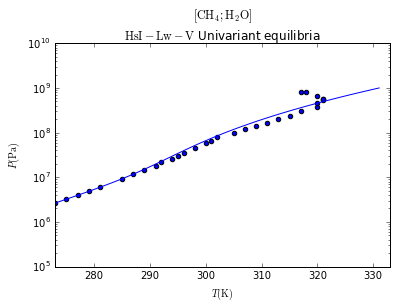

In [18]:
#define a script to calculate the phase diagram
def PhaseDiagram():
    from scipy.optimize import bisect as SOLVE

    #specified gas composition
    x=np.array([1.])

    #definition of residue function for numerical solution along the PxT phase diagram
    def RES(T,P):
        Dmu_EL_Lw=saito_EL_Lw(T,P)
        fug_G=PR_fug_G(T,P,x)[0]
        Dmu_H_EL=vdwnp_H_EL(T,fug_G)
        return Dmu_EL_Lw+Dmu_H_EL
    
    #define a grid
    Tgrid = np.zeros(100)
    Pgrid = np.logspace(5,9,100)
    
    #seek solution for T for each P in the grid
    for i in range(100):

        #call the solver imported from scipy.optimize
        ans=SOLVE(
            #define a lambda function for thew numerical method
            #so that the numerical method can treat the RES of T and P as a function of 1 variable and tehrefore provide solutions for T for each given P
            lambda T, P=Pgrid[i]: RES(T,P)
            #set lower and upper search limits and tolerances
            , 150, 400, xtol=1e-9, rtol=1e-9, maxiter=100, full_output=True, disp=True)

    #record solution after each point in the grid
        Tgrid[i]=ans[0]

    #plot:
    
    #import plotting tools
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    #activate figure
    #plot calculated data
    plt.figure(1)
    plt.semilogy(Tgrid,Pgrid)
    
    #set plot limits
    plt.xlim([273,333])
    plt.ylim([1e5,1e10])

    #Let's also plot some experimental data along our calculations
    
    #retrieve data from a text file provided with this notebook
    table = np.loadtxt('support-files/C1-sI-hydrates-HLwGequilibria-expData.txt', #data from NIST
                       dtype='float', 
                       comments='#', 
                       converters=None,
                       skiprows=0,
                       usecols=None,
                       unpack=False,
                       ndmin=0)
    
    #split data into arrays for T and P
    T_eq = table[:,0]
    P_eq = table[:,1]    
    
    #plot exp data as scatter
    plt.scatter(T_eq,P_eq)
    
    #format
    plt.title(r'$[\mathrm{CH}_4; \mathrm{H}_2\mathrm{O}]$'+'\n'+'$\mathrm{HsI-Lw-V}$'+' Univariant equilibria')
    plt.xlabel(r'$T\mathrm{(K)}$')
    plt.ylabel(r'$P\mathrm{(Pa)}$')

    #show plot!
    plt.show()    
    return

#call the phase diagram script
_=PhaseDiagram()

# Coming soon:
>- preserve this notebook for beginner lectures
>- present improvements in intermediate notebooks

* add ice below 273 K
* add Langmuir parameters for
* add acurate correlation for Lw and H volumes and its Poynting integrals
* add activity coefficient model for water soluble inhibitors
* add ethanol' inhibitor-guest dual-role


